---
title: PA 9.2
author: Sujanya Srinath
format:
    html:
        toc: true
        code-fold: true
theme: morph
embed-resources: true
---

In [15]:
# asked chatgpt how to suppress convergence warning since it was appearing in the output
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)


Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [16]:
import numpy as np
import pandas as pd
from sys import exit
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector


In [27]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
ha.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


In [28]:
#fitting a multiclass KNN
X = ha.drop(columns=["cp",'output'])
y = ha["cp"]

#asked chatgpt for syntax and outline for the pipeline and predicting
ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, drop = "first", handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform="pandas")

lr_pipeline = Pipeline(
  [("preprocessing", ct),
  ("knn", KNeighborsClassifier(n_neighbors=5))]
)

knn_pred = cross_val_predict(lr_pipeline, X, y, cv=5)

print("KNN Classification Report:")
print(classification_report(y, knn_pred))

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.67      0.57       128
           1       0.13      0.11      0.12        44
           2       0.32      0.22      0.26        81
           3       0.20      0.05      0.08        20

    accuracy                           0.40       273
   macro avg       0.29      0.26      0.26       273
weighted avg       0.36      0.40      0.37       273



Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.65      0.59       128
           1       0.28      0.11      0.16        44
           2       0.33      0.41      0.36        81
           3       0.00      0.00      0.00        20

    accuracy                           0.44       273
   macro avg       0.29      0.29      0.28       273
weighted avg       0.40      0.44      0.41       273



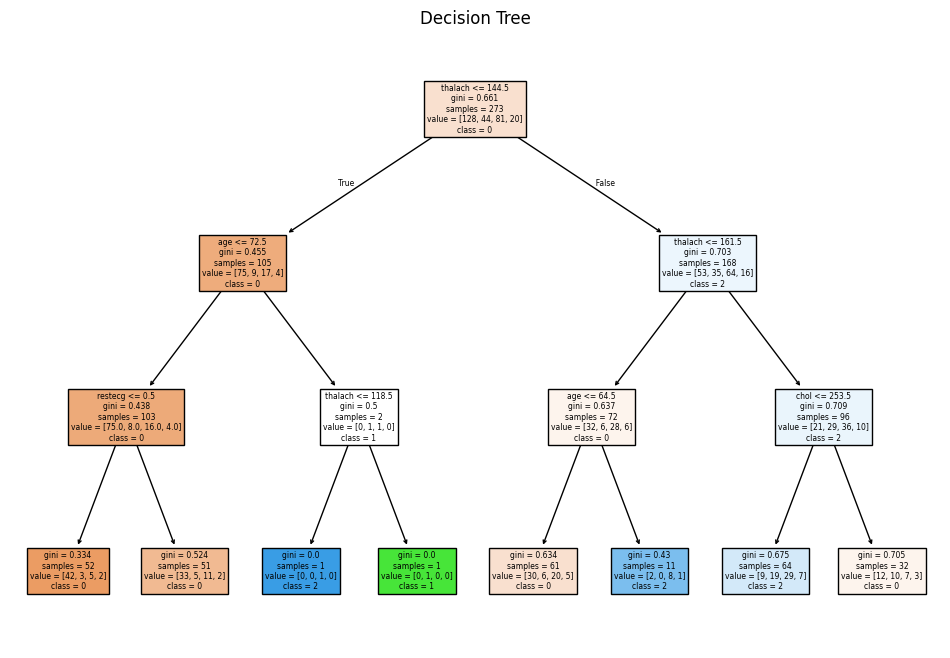

In [30]:
#Decision Tree
#asked chatgpt for syntax
dt = DecisionTreeClassifier(max_depth=3)

dt_pred = cross_val_predict(dt, X, y, cv=5)

print("Decision Tree Classification Report:")
print(classification_report(y, dt_pred))

# Fitting the model on the full dataset - useful for plotting
dt.fit(X, y)

# Plot the Decision Tree - using matplotlib.pyplot - easier than using plotnine in this case\
#asked chatgpt for syntax
plt.figure(figsize=(12, 8))
plot_tree(dt, feature_names=X.columns, class_names=[str(c) for c in dt.classes_], filled=True)
plt.title("Decision Tree")
plt.show()


In [31]:
#LDA
#asked chatgpt for syntax
lda = LinearDiscriminantAnalysis()

# Cross-validated predictions
lda_pred = cross_val_predict(lda, X, y, cv=5)

# Evaluation
print("LDA Classification Report:")
print(classification_report(y, lda_pred))


LDA Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.75      0.64       128
           1       0.40      0.05      0.08        44
           2       0.32      0.36      0.34        81
           3       0.00      0.00      0.00        20

    accuracy                           0.47       273
   macro avg       0.32      0.29      0.26       273
weighted avg       0.42      0.47      0.41       273



## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

In [21]:
# new column creation from coursebook
ha["cp_is_0"] = (ha["cp"] == 0).astype(int)
ha["cp_is_1"] = (ha["cp"] == 1).astype(int)
ha["cp_is_2"] = (ha["cp"] == 2).astype(int)
ha["cp_is_3"] = (ha["cp"] == 3).astype(int)

# cp is 3 - outline from chatgpt
X = ha.drop(columns=["cp", "cp_is_0", "cp_is_1", "cp_is_2", "cp_is_3",'output'])
y = ha["cp_is_3"]

model1 = LogisticRegression().fit(X, y)
y_pred = cross_val_predict(model1, X, y, cv=5)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       253
           1       0.00      0.00      0.00        20

    accuracy                           0.92       273
   macro avg       0.46      0.50      0.48       273
weighted avg       0.86      0.92      0.89       273



In [22]:
# cp is 0 - outline from chatgpt
y = ha["cp_is_0"]
model = LogisticRegression().fit(X, y)
y_pred = cross_val_predict(model, X, y, cv=5)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.72      0.68       145
           1       0.64      0.56      0.60       128

    accuracy                           0.64       273
   macro avg       0.64      0.64      0.64       273
weighted avg       0.64      0.64      0.64       273



In [23]:
# cp is 1 - outline from chatgpt
y = ha["cp_is_1"]
model = LogisticRegression().fit(X, y)
y_pred = cross_val_predict(model, X, y, cv=5)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91       229
           1       0.00      0.00      0.00        44

    accuracy                           0.83       273
   macro avg       0.42      0.50      0.45       273
weighted avg       0.70      0.83      0.76       273



In [24]:
# cp is 2 - outline from chatgpt
y = ha["cp_is_2"]
model = LogisticRegression().fit(X, y)
y_pred = cross_val_predict(model, X, y, cv=5)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.90      0.78       192
           1       0.17      0.05      0.08        81

    accuracy                           0.65       273
   macro avg       0.43      0.48      0.43       273
weighted avg       0.54      0.65      0.57       273




*   When cp is less than 3, the F1 score is 0.96; when cp is equal to 3, the F1 value is 0.00. This suggests that while the model does a great job when cp is not 3, it is unable to detect situations in which cp is 3.
*   When cp is equal to zero, the F1 score is 0.60, and when cp is not equal to zero, it is 0.68. This shows that the model works effectively both when cp is 0 and when it is not 0.
*   When cp is equal to 1, the F1 score is 0.00, and when cp is not equal to 1, it is 0.91. This suggests that while the model does a great job when cp is not 1, it is unable to detect situations in which cp is 1.
*   When cp is equal to 2, the F1 score is 0.08; when cp is not equal to 2, the F1 value is 0.78. This suggests that while the model does a great job when cp is not 2, it is unable to recognize situations in which cp is 2.

Since the OvR method has the highest F1 score for category 0, it performs best when cp = 0.





## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

In [25]:
# outline from chatgpt, asked which columns to drop
ha_0_1 = ha[~ha['cp'].isin([2, 3])]
X = ha_0_1.drop(columns=["cp", "cp_is_0", "cp_is_1", "cp_is_2", "cp_is_3",'output'])

y = ha_0_1["cp_is_0"]
model = LogisticRegression().fit(X, y)
y_pred = cross_val_predict(model, X, y, cv=5)
print(f"roc_auc_score for 0 and 1: {roc_auc_score(y, y_pred)}")

ha_0_2 = ha[~ha['cp'].isin([1, 3])]
X = ha_0_2.drop(columns=["cp", "cp_is_0", "cp_is_1", "cp_is_2", "cp_is_3",'output'])
y = ha_0_2["cp_is_0"]
model = LogisticRegression().fit(X, y)
y_pred = cross_val_predict(model, X, y, cv=5)
print(f"roc_auc_score for 0 and 2: {roc_auc_score(y, y_pred)}")

ha_0_3 = ha[~ha['cp'].isin([1, 2])]
X = ha_0_3.drop(columns=["cp", "cp_is_0", "cp_is_1", "cp_is_2", "cp_is_3",'output'])
y = ha_0_3["cp_is_0"]
model = LogisticRegression().fit(X, y)
y_pred = cross_val_predict(model, X, y, cv=5)
print(f"roc_auc_score for 0 and 3: {roc_auc_score(y, y_pred)}")

roc_auc_score for 0 and 1: 0.6235795454545454
roc_auc_score for 0 and 2: 0.5719039351851852
roc_auc_score for 0 and 3: 0.4765625


model with 0 and 1 type has a better roc auc score and therefore was the pair that the ovo approach was best at distingishing